In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from hybridpy.learning import dynamicprogramming, ensemblepredictor
from hybridpy.dataset import triploader
import osmapping
import glob
import math
import numpy as np

In [3]:
dname = '/Users/astyler/projects/ChargeCarData/illah/'
trips = []
fnames = glob.glob(dname+'*.csv')
for fname in fnames:
    trips.append(triploader.load(fname))
    
len(trips)

/Users/astyler/anaconda/lib/python2.7/site-packages/hybridpy/dataset/triploader.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  trip.Acceleration[0] = 0


575

In [4]:
trips[4].head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,Heading,Gradient
0,40.450752,-79.929198,247.734948,2.98,13.28,13.275005,0.000000,3342.2758,0.0000,1000,1267506595000,0,2.977927,0.001656
1,40.450771,-79.929353,247.758603,2.96,10.00,11.021376,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,2.936109,0.001656
2,40.450788,-79.929469,247.780730,2.96,10.00,9.175370,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,2.891831,0.002012
3,40.450804,-79.929585,247.801039,2.90,6.74,6.543060,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,2.846653,0.001850
4,40.450819,-79.929663,247.819220,2.70,2.74,3.169773,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,2.808650,0.002329


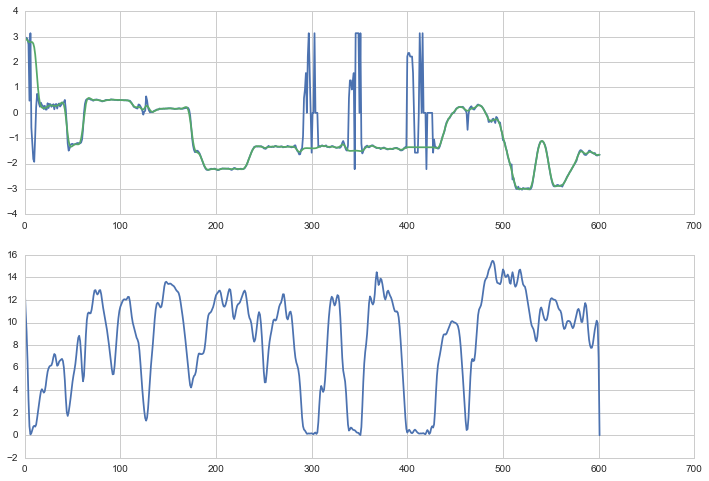

In [5]:
plt.figure(figsize=(12,8))
ax = plt.subplot(211)
ax.plot(trips[4].Bearing)
ax.plot(trips[4].Heading)

ax = plt.subplot(212)
ax.plot(trips[4].Speed)


In [6]:
buffr = 0.01
mins=[(min(trip.Longitude) -buffr,min(trip.Latitude)-buffr) for trip in trips]
maxs=[(max(trip.Longitude) + buffr,max(trip.Latitude)+buffr) for trip in trips]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))
print ll
print ur


[-80.274581999999995, 40.273409999999998]
[-79.510327000000004, 40.505786999999998]


In [7]:
ll = [-80.0, 40.40]
ur = [-79.87, 40.48]
mymap = osmapping.MLMap(ll,ur)

In [8]:
for trip in trips:
    trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

In [9]:
mymap.load_shape_file('./shapefiles/pittsburgh/line.shp')
mymap.load_shape_file('./shapefiles/pittsburgh/polygon.shp')

In [10]:
mymap.clear_selected_shapes()

road = {'edgecolor':'white','lw':3, 'facecolor':'none','zorder':6};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#BBDDBB',edgecolor='none',zorder=4)
mymap.select_shape('waterway','riverbank',facecolor='#CCCCEE', edgecolor='none', zorder=5)

mymap.select_shape('natural','water',facecolor='#CCCCEE', edgecolor='none', zorder=5)

In [11]:
training = trips[0:4]+trips[5:]
test = trips[4]

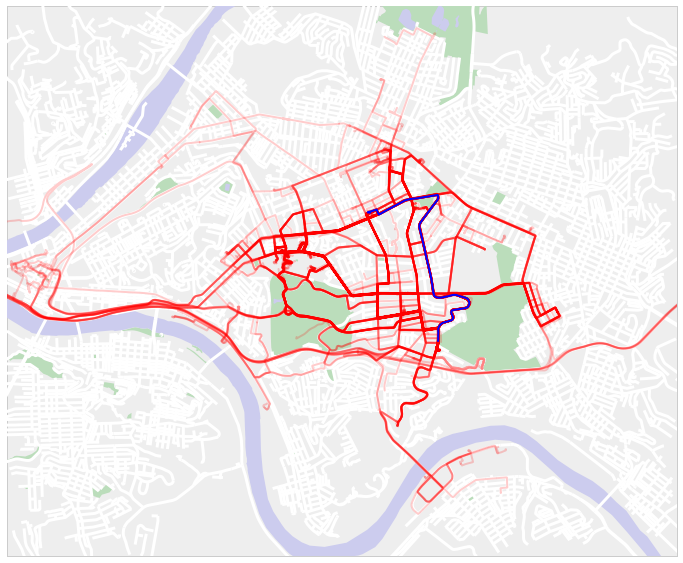

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (idx,trip) in enumerate(training):
    ax.plot(trip.x, trip.y, lw=2, alpha=0.2, c='red', zorder=99)
    
ax.plot(test.x, test.y, lw=2, alpha=1, c='blue', zorder=100)

In [13]:
test.head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,Heading,Gradient,x,y
0,40.450752,-79.929198,247.734948,2.98,13.28,13.275005,0.000000,3342.2758,0.0000,1000,1267506595000,0,2.977927,0.001656,8315.788601,7858.642763
1,40.450771,-79.929353,247.758603,2.96,10.00,11.021376,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,2.936109,0.001656,8298.534080,7861.411421
2,40.450788,-79.929469,247.780730,2.96,10.00,9.175370,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,2.891831,0.002012,8285.621019,7863.888641
3,40.450804,-79.929585,247.801039,2.90,6.74,6.543060,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,2.846653,0.001850,8272.707958,7866.220143
4,40.450819,-79.929663,247.819220,2.70,2.74,3.169773,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,2.808650,0.002329,8264.025038,7868.405927


In [32]:
features = ['Latitude', 'Longitude', 'Heading', 'Speed', 'Acceleration', 'Power', 'TotalEnergyUsed']
feature_weights =  [1,1,1e1,1e-1,0,0,1e-1]
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

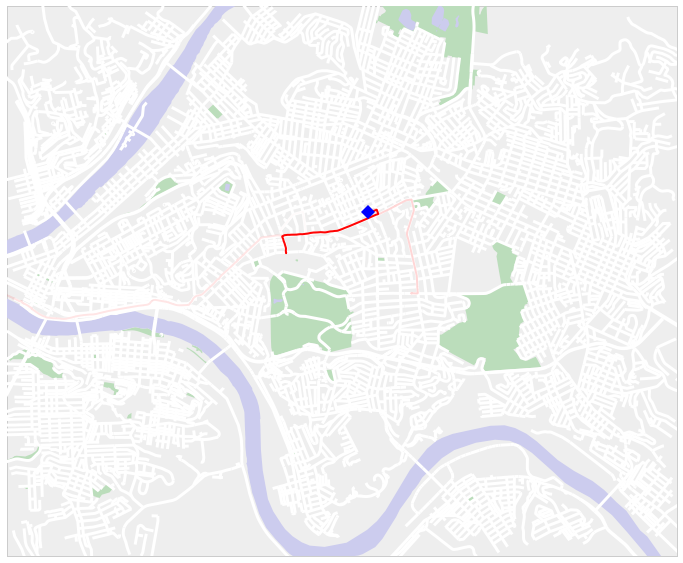

In [35]:
index = 15
results = ep.predict(test.iloc[index], 1e-2)
#best_weight = max(results)[0]
#results = [(w/best_weight, i) for (w,i) in results]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (r, trip) in zip(results, training):
    idx = r[1]
    ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=2, alpha=r[0], c='red', zorder=99)
    #ax.plot(trip.x.iloc[idx], trip.y.iloc[idx], 'gD', alpha=1, markersize=20*r[0], zorder=100)

ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)


In [36]:
results

[(0.0, 71),
 (1.6237080155787412e-06, 310),
 (1.3547325137531998e-13, 297),
 (9.7411324759327846e-165, 294),
 (2.7287997400326735e-25, 569),
 (1.3462954097418295e-284, 212),
 (0.0, 210),
 (9.7655076714737239e-240, 632),
 (0.0, 133),
 (0.0, 276),
 (0.0, 327),
 (0.0, 22),
 (0.0, 8),
 (1.1492568859486745e-229, 686),
 (0.0, 4),
 (0.0, 290),
 (0.0, 610),
 (0.0, 89),
 (0.0, 58),
 (1.1545890896115089e-213, 363),
 (0.0, 89),
 (7.9636988829072387e-231, 92),
 (8.4624910931068646e-304, 494),
 (0.0, 93),
 (8.2846775990286707e-206, 709),
 (0.0, 56),
 (1.0397438004302031e-197, 663),
 (0.0, 88),
 (1.5275171098099317e-174, 438),
 (6.8051550135387435e-236, 31),
 (0.0, 513),
 (1.6757288637688938e-220, 599),
 (0.0, 30),
 (1.5304345220260969e-206, 293),
 (0.0, 78),
 (4.9971973654563837e-242, 607),
 (0.0, 293),
 (9.9866713505548959e-196, 96),
 (5.2157790623233672e-239, 571),
 (1.8098550523627801e-244, 402),
 (0.0, 19),
 (0.0, 130),
 (0.0, 1059),
 (2.7499610790105413e-150, 528),
 (1.6094852803229454e-207, 2

In [41]:
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

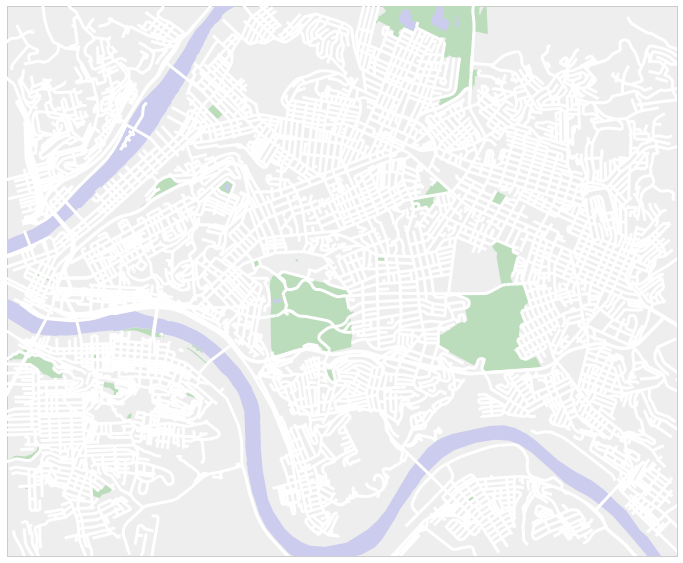

In [42]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')
weights = []  
for index in range(5,len(test),5):
    results = ep.predict(test.iloc[index], sigma=1e-2)
    #results = [(norm(r[0], 1e-4), r[1]) for r in ep.predict(test.iloc[index])]
    #results = [(1.0/r[0], r[1]) for r in ep.predict(test.iloc[index])]
    #best_match = max(results)
    #results = [(w/best_match[0], i) for (w,i) in results]

    lines = []
    for (r, trip) in zip(results, training):
        idx = r[1]
        line = ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=4, alpha=r[0], c='red', zorder=99)
        lines.append(line[0])
        
    pt = ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)[0]
    plt.savefig('video/aframe'+str(index)+'.jpg')
    
    
    for line in lines:
        line.remove()
        del line
    pt.remove()